In [1]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
import random
import cvxopt as opt
from cvxopt import blas, solvers

from sklearn.model_selection import train_test_split

import keras.backend as K
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Flatten, Dense

In [2]:
# Plotting aesthetics
# From https://pat-laub.github.io/DeepLearningForActuaries/Lecture-7-Natural-Language-Processing/natural-language-processing.html#/an-aside-on-colours
# This is the default colour scheme.
colours = [
    "tab:blue", "tab:orange", "tab:green", "tab:red",
    "tab:purple", "tab:brown", "tab:pink","tab:gray",
    "tab:olive", "tab:cyan",
]
colours.remove("tab:orange")
# Set the default color scheme so that this orange is skipped.
import cycler
plt.rcParams["axes.prop_cycle"] = cycler.cycler(color=colours)

plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

Importing Data (for reference)

In [3]:
def get_prices(tickers):
  '''
  Extracts the daily closing prices of chosen tickers from yfinance

  inputs: tickers - list of tickers
  returns: DataFrame of historical daily closing prices of chosen tickers
  '''
  close_prices = pd.DataFrame()
  for ticker in tickers:
    obj = yf.Ticker(ticker)
    hist = obj.history(start = "2012-06-01",
                          end = "2022-06-01",
                          auto_adjust = True,
                          interval = "1d").dropna()
    close_prices[ticker] = hist.Close

  return close_prices

MV and NN helper functions

In [4]:
def create_X_y(prices, returns, lookback, gap, horizon, concat):
  # Adapted from https://deepdow.readthedocs.io/en/latest/auto_examples/end_to_end/getting_started.html#sphx-glr-auto-examples-end-to-end-getting-started-py
  '''
  Create samples of lookback prices/returns and horizon returns

  inputs: 
    prices - DataFrame of historical daily closing prices
    returns - Dataframe of returns, same observations as prices
  returns: 
    X - np array of samples of lookback prices/returns
    y - np array of samples of horizon returns
  '''

  assert prices.shape[0] == returns.shape[0]

  returns = np.array(returns)
  n_days = returns.shape[0]
  X_list, y_list = [], []

  # Concatenate prices and returns if specified
  if concat:
    prices_returns = np.concatenate([prices, returns], axis = 1)
    for i in range(lookback, n_days - horizon - gap + 1):
      X_list.append(prices_returns[i - lookback: i, :])
      y_list.append(returns[(i + gap): (i + gap + horizon), :])
  else:
    for i in range(lookback, n_days - horizon - gap + 1):
      X_list.append(returns[i - lookback: i, :])
      y_list.append(returns[(i + gap): (i + gap + horizon), :])

  X = np.stack(X_list, axis=0)
  y = np.stack(y_list, axis=0)

  return X, y

In [5]:
def MV_weights(returns):
  # Adapted from https://github.com/zhangyi-hu/pymcef/blob/master/examples/1.%20When%20mean%20variance%20models%20fail.ipynb
  '''
  Computes the portfolio weights which result in the greatest sharpe ratio

  inputs: returns - numpy array of returns, with timestep rows and stocks columns
  returns: x_sharpe - optimal portfolio weights
  '''
  # returns should have shape (n_days, n_stocks)
  expected_returns = returns.mean(axis = 0)
  cov_matrix = np.cov(returns.T)

  num_points = 100
  n_assets = len(expected_returns)

  # Defining matrices for optimisation
  Sigma = opt.matrix(cov_matrix)
  mu_vec = opt.matrix(expected_returns)
  zero_vec = opt.matrix(0.0, (n_assets, 1))
  one_vec = opt.matrix(1.0, (n_assets, 1))
  I = opt.matrix(np.eye(n_assets))
  A = opt.matrix([one_vec.T, mu_vec.T])

  sharpe_max = -1_000_000

  # suppress optim output
  solvers.options['show_progress'] = False

  Rs_ef = np.linspace(min(mu_vec), max(mu_vec), num_points)
  for R in Rs_ef:
    b = opt.matrix([1.0, R])
    sol = solvers.qp(P = Sigma, q = zero_vec, G = -I, h = zero_vec, A = A, b = b)
    
    sd = np.sqrt(2 * sol['primal objective'])
    sharpe = R/sd
    if sharpe > sharpe_max:
      sharpe_max = sharpe
      x_sharpe = np.array(sol["x"]).flatten()

  return x_sharpe

In [6]:
def MV_returns(X_samples, y_samples):
  '''
  Computes the portfolio weights which result in the greatest sharpe ratio

  inputs: 
    X_samples - numpy array of lookback returns, with shape (n_samples, lookback, n_stocks)
    y_samples - numpy array of horizon returns, with shape (n_samples, horizon, n_stocks)
  returns: 
    portfolio_returns_array - numpy array of horizon returns, with shape (n_samples, horizon)
  '''
  
  assert X_samples.shape[0] == y_samples.shape[0]
  assert X_samples.shape[2] == y_samples.shape[2]

  n_samples = X_samples.shape[0]

  portfolio_returns_list = []

  for t in range(n_samples):
    lookback_returns = X_samples[t]
    x_optimal = MV_weights(lookback_returns)
    horizon_returns = y_samples[t]
    portfolio_returns = np.dot(horizon_returns, x_optimal)

    # convert to 2d array then append
    portfolio_returns_list.append(portfolio_returns[np.newaxis, :])

  portfolio_returns_array = np.concatenate(portfolio_returns_list, axis = 0)
  return portfolio_returns_array

In [7]:
def sharpe_ratio(portfolio_returns):
  '''
  Computes sharpe ratio of portfolio

  inputs: portfolio_returns - array of portfolio returns
  returns: sharpe ratio
  '''
  portfolio_sharpe = portfolio_returns.mean() / portfolio_returns.std()
  return portfolio_sharpe

In [8]:
# Adapted from https://github.com/shilewenuw/deep-learning-portfolio-optimization/blob/main/Model.py
def sharpe_loss_wrapper(n_stocks):
  def sharpe_loss(y_true, y_pred):
    # y_true corresponds to the horizon returns
    # y_pred will coresspond to asset weights
    weights_reshape = tf.reshape(y_pred, (-1, 1, n_stocks))

    portfolio_returns = tf.reduce_sum(tf.multiply(y_true, weights_reshape), axis = 2)
    sharpes = K.mean(portfolio_returns, axis = 1) / K.std(portfolio_returns, axis = 1)

    # loss is negative of Sharpe ratio
    return -sharpes
  return sharpe_loss


Train Validation Test Split

In [9]:
tickers = ["WOW.AX", "QBE.AX", "COH.AX", "ORG.AX", "TWE.AX",
           "BHP.AX", "CBA.AX", "TLS.AX", "GMG.AX", "ALL.AX"]
# First 3 tickers for 3 ticker case
# First 5 tickers for 5 ticker case
# All 10 tickers for 10 ticker case

# 60/20/20 split
prices = pd.read_csv("prices.csv", index_col = 0)
returns = prices.pct_change().iloc[1:]

# Remove first index of prices
prices = prices.iloc[1:]
assert prices.shape[0] == returns.shape[0]

n_obs = returns.shape[0]
n_train = int(0.6 * n_obs)
n_val = int(0.2 * n_obs)
n_test = n_obs - n_train - n_val

indices_train = list(range(n_train))
indices_val = list(range(n_train, n_train + n_val))
indices_test = list(range(n_train + n_val, n_train + n_val + n_test))

print(f"# obs: {n_obs}\n# train: {n_train}\n# val: {n_val}\n# test: {n_test}")

# obs: 2531
# train: 1518
# val: 506
# test: 507


Plots of prices

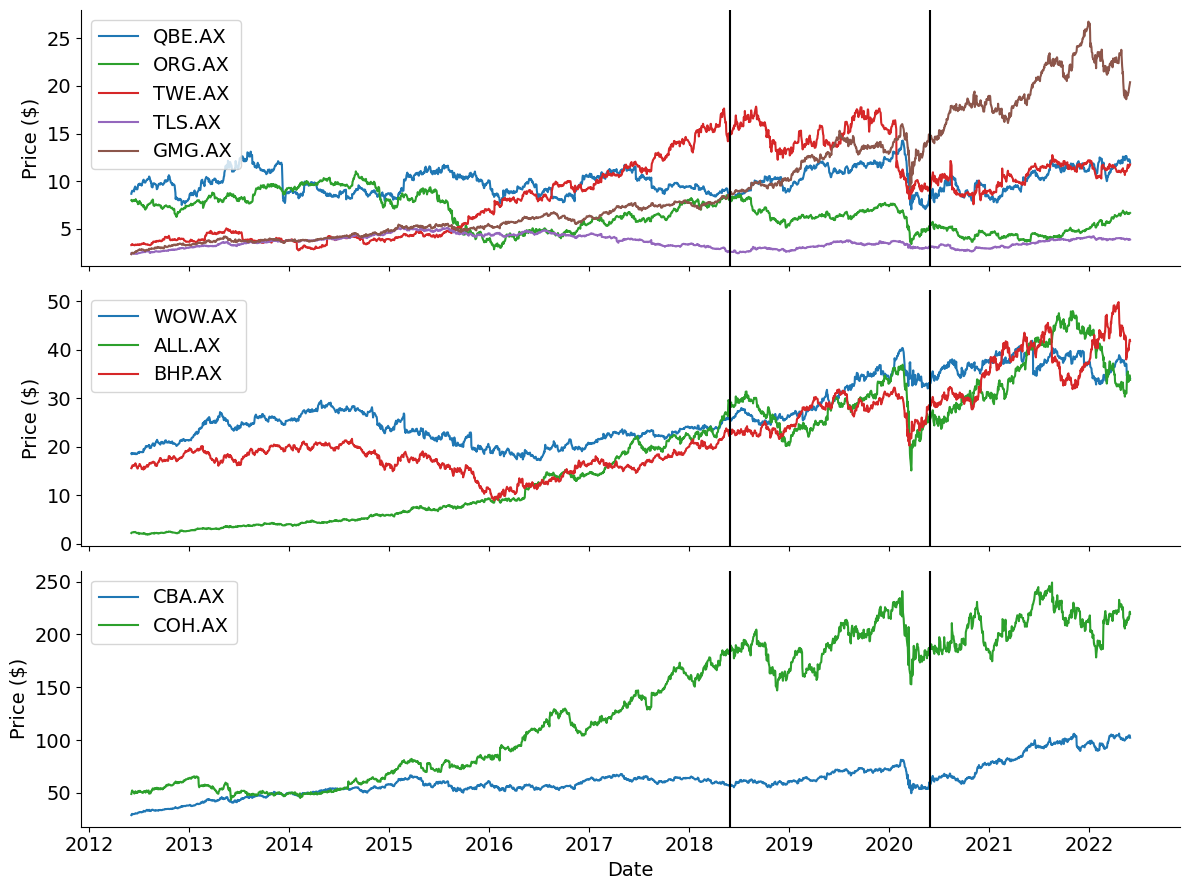

In [10]:
prices.reset_index(inplace = True)
prices["Date"] = pd.to_datetime(prices["Date"], utc = True)
prices["Date"] = prices["Date"].dt.date
prices.set_index("Date", inplace = True)

fig, axs = plt.subplots(3, 1, tight_layout = True, figsize = (12, 9), sharex = "col")

axs[0].plot(prices["QBE.AX"], label = "QBE.AX")
axs[0].plot(prices["ORG.AX"], label = "ORG.AX")
axs[0].plot(prices["TWE.AX"], label = "TWE.AX")
axs[0].plot(prices["TLS.AX"], label = "TLS.AX")
axs[0].plot(prices["GMG.AX"], label = "GMG.AX")


axs[1].plot(prices["WOW.AX"], label = "WOW.AX")
axs[1].plot(prices["ALL.AX"], label = "ALL.AX")
axs[1].plot(prices["BHP.AX"], label = "BHP.AX")

axs[2].plot(prices["CBA.AX"], label = "CBA.AX")
axs[2].plot(prices["COH.AX"], label = "COH.AX")
axs[2].set_xlabel("Date", fontsize = 14)


for ax in axs.flat:
    ax.axvline(x = prices.index[n_train], color = "black")
    ax.axvline(x = prices.index[n_train + n_val], color = "black")
    ax.legend(fontsize = 14)
    ax.set_ylabel("Price ($)", fontsize = 14)
    ax.tick_params(axis = "y", labelsize = 14)
    ax.tick_params(axis = "x", labelsize = 14)



Varying Lookback

In [11]:
%%capture
results = {}
gap = 2
horizon = 5
for lookback in [5, 10, 20, 50]:
    results[f"l{lookback}g{gap}h{horizon}"] = {}
    for num_stocks in [3, 5, 10]:
        X_train, y_train = create_X_y(
            prices = prices.iloc[indices_train, :num_stocks],
            returns = returns.iloc[indices_train, :num_stocks],
            lookback = lookback, 
            gap = gap, 
            horizon = horizon,
            concat = False)
        X_val, y_val = create_X_y(
            prices = prices.iloc[indices_val, :num_stocks],
            returns = returns.iloc[indices_val, :num_stocks],
            lookback = lookback, 
            gap = gap, 
            horizon = horizon,
            concat = False)
        X_test, y_test = create_X_y(
            prices = prices.iloc[indices_test, :num_stocks],
            returns = returns.iloc[indices_test, :num_stocks],
            lookback = lookback, 
            gap = gap, 
            horizon = horizon,
            concat = False)

        # Generating portfolio returns for each sample
        portfolio_returns_train = MV_returns(X_train, y_train)
        portfolio_returns_val = MV_returns(X_val, y_val)

        # Portfolio sharpes for each sample
        portfolio_sharpes_train = portfolio_returns_train.mean(axis = 1) / portfolio_returns_train.std(axis = 1)
        portfolio_sharpes_val = portfolio_returns_val.mean(axis = 1) / portfolio_returns_val.std(axis = 1) 

        # Storing results in dictionary
        results[f"l{lookback}g{gap}h{horizon}"][f"MV_returns_train_{num_stocks}"] = portfolio_returns_train
        results[f"l{lookback}g{gap}h{horizon}"][f"MV_returns_val_{num_stocks}"] = portfolio_returns_val

        # Taking mean of portfolio sharpes
        results[f"l{lookback}g{gap}h{horizon}"][f"MV_sharpe_train_{num_stocks}"] = portfolio_sharpes_train.mean()
        results[f"l{lookback}g{gap}h{horizon}"][f"MV_sharpe_val_{num_stocks}"] = portfolio_sharpes_val.mean()


MV Results

In [12]:
for lookback in [5, 10, 20, 50]:
    print("sharpe train:")
    for num_stocks in [3, 5, 10]:
        print(f'lookback = {lookback}, num_stocks = {num_stocks}: {100 * results[f"l{lookback}g{gap}h{horizon}"][f"MV_sharpe_train_{num_stocks}"]}')
    print("sharpe val:")
    for num_stocks in [3, 5, 10]:
        print(f'lookback = {lookback}, num_stocks = {num_stocks}: {100 * results[f"l{lookback}g{gap}h{horizon}"][f"MV_sharpe_val_{num_stocks}"]}')

sharpe train:
lookback = 5, num_stocks = 3: 8.491126909645681
lookback = 5, num_stocks = 5: 6.547062972753967
lookback = 5, num_stocks = 10: 10.877024287159305
sharpe val:
lookback = 5, num_stocks = 3: 13.542016979211557
lookback = 5, num_stocks = 5: 8.452545336182581
lookback = 5, num_stocks = 10: 8.681081601744218
sharpe train:
lookback = 10, num_stocks = 3: 9.983632613781992
lookback = 10, num_stocks = 5: 8.282286888952397
lookback = 10, num_stocks = 10: 11.759922580882554
sharpe val:
lookback = 10, num_stocks = 3: 15.283053402668509
lookback = 10, num_stocks = 5: 10.685247862646953
lookback = 10, num_stocks = 10: 13.130677930163884
sharpe train:
lookback = 20, num_stocks = 3: 10.30292893697994
lookback = 20, num_stocks = 5: 8.050794992219085
lookback = 20, num_stocks = 10: 11.313575210876724
sharpe val:
lookback = 20, num_stocks = 3: 10.795220330453809
lookback = 20, num_stocks = 5: 9.627661546148486
lookback = 20, num_stocks = 10: 9.910853048457104
sharpe train:
lookback = 50, num

In [13]:
%%capture
# suppress output
results = {}
hist = {}
gap = 2
horizon = 5
for lookback in [5, 10, 20, 50]:
    results[f"l{lookback}g{gap}h{horizon}"] = {}
    for n_stocks in [3, 5, 10]:
        X_train, y_train = create_X_y(
            prices = prices.iloc[indices_train, :n_stocks],
            returns = returns.iloc[indices_train, :n_stocks],
            lookback = lookback,
            gap = gap,
            horizon = horizon,
            concat = True)

        X_val, y_val = create_X_y(
            prices = prices.iloc[indices_val, :n_stocks],
            returns = returns.iloc[indices_val, :n_stocks],
            lookback = lookback,
            gap = gap,
            horizon = horizon,
            concat = True)

        tf.random.set_seed(1234)
        # Building LSTM Model
        LSTM_model = Sequential([
            LSTM(64, input_shape = (lookback, 2 * n_stocks)),
            Flatten(),
            Dense(n_stocks, activation = "softmax")
        ])

        LSTM_model.compile(loss = sharpe_loss_wrapper(n_stocks), optimizer = "adam")
        hist[f"l{lookback}n{n_stocks}"] = LSTM_model.fit(
            X_train, y_train, epochs=50, shuffle=False,
            validation_data = (X_val, y_val))

        sharpe_train = -LSTM_model.evaluate(X_train, y_train)
        sharpe_val = -LSTM_model.evaluate(X_val, y_val)

        # Storing results in dictionary

        results[f"l{lookback}g{gap}h{horizon}"][f"NN_sharpe_train_{n_stocks}"] = sharpe_train
        results[f"l{lookback}g{gap}h{horizon}"][f"NN_sharpe_val_{n_stocks}"] = sharpe_val

NN Results

In [14]:
for lookback in [5, 10, 20, 50]:
    print("sharpe train:")
    for n_stocks in [3, 5, 10]:
        print(f'lookback = {lookback}, n_stocks = {n_stocks}: {100 * results[f"l{lookback}g{gap}h{horizon}"][f"NN_sharpe_train_{n_stocks}"]}')
    print("sharpe val:")
    for n_stocks in [3, 5, 10]:
        print(f'lookback = {lookback}, n_stocks = {n_stocks}: {100 * results[f"l{lookback}g{gap}h{horizon}"][f"NN_sharpe_val_{n_stocks}"]}')

sharpe train:
lookback = 5, n_stocks = 3: 13.574334979057312
lookback = 5, n_stocks = 5: 15.397937595844269
lookback = 5, n_stocks = 10: 27.346697449684143
sharpe val:
lookback = 5, n_stocks = 3: 10.761270672082901
lookback = 5, n_stocks = 5: 6.966082006692886
lookback = 5, n_stocks = 10: 12.095467746257782
sharpe train:
lookback = 10, n_stocks = 3: 13.738687336444855
lookback = 10, n_stocks = 5: 14.137780666351318
lookback = 10, n_stocks = 10: 22.101400792598724
sharpe val:
lookback = 10, n_stocks = 3: 10.19228845834732
lookback = 10, n_stocks = 5: 6.798999011516571
lookback = 10, n_stocks = 10: 12.543468177318573
sharpe train:
lookback = 20, n_stocks = 3: 13.738159835338593
lookback = 20, n_stocks = 5: 14.758805930614471
lookback = 20, n_stocks = 10: 27.33897864818573
sharpe val:
lookback = 20, n_stocks = 3: 10.558366775512695
lookback = 20, n_stocks = 5: 2.5597935542464256
lookback = 20, n_stocks = 10: 15.313269197940826
sharpe train:
lookback = 50, n_stocks = 3: 13.581578433513641


NN Loss Plots

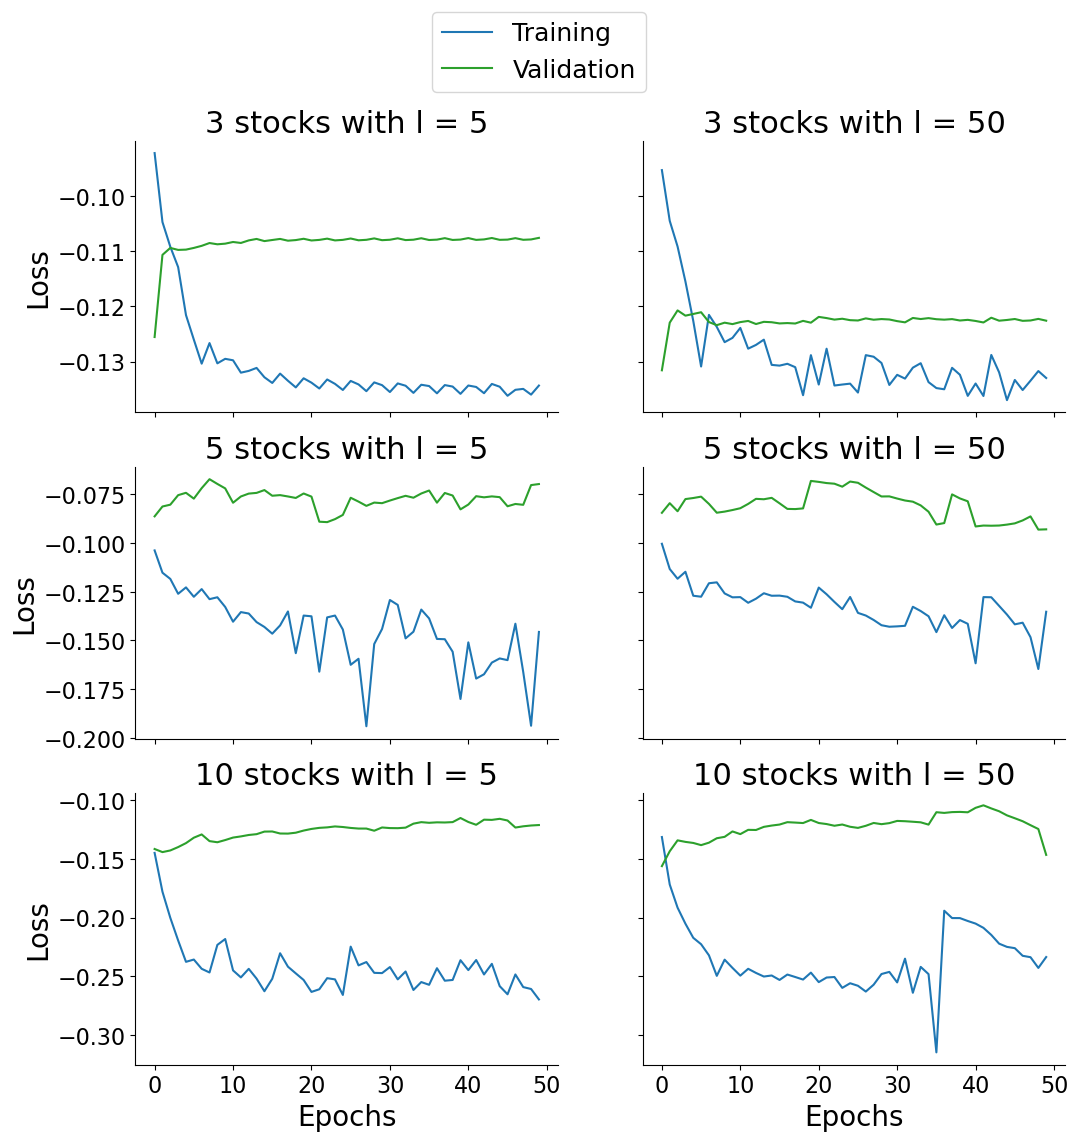

In [15]:
fig, axs = plt.subplots(3, 2, figsize = (12, 12), sharey = "row")
for col in range(0, 2):
    for row in range(0, 3):
        if row == 0:
            n = 3
        elif row == 1:
            n = 5
        elif row == 2:
            n = 10

        if col == 0:
            l = 5
        elif col == 1:
            l = 50
        
        axs[row, col].plot(hist[f"l{l}n{n}"].history["loss"], label = "Training")
        axs[row, col].plot(hist[f"l{l}n{n}"].history["val_loss"], label = "Validation")
        axs[row, col].set_title(f"{n} stocks with l = {l}", fontsize = 22)

for ax in axs.flat:
    ax.set_xlabel("Epochs", fontsize = 20)
    ax.set_ylabel("Loss", fontsize = 20)
    ax.tick_params(axis = "x", labelsize = 16)
    ax.tick_params(axis = "y", labelsize = 16)

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', fontsize = 18)


Hyperparameter tuning for lookback l = 5, gap g = 2, horizon h = 5

In [16]:
lookback = 5
gap = 2
horizon = 5

X_train = {}
y_train = {}
X_val = {}
y_val = {}

sharpes_train = {}
sharpes_val = {}
hist = {}

# Creating data samples
for n_stocks in [3, 5, 10]:
    X_train[str(n_stocks)], y_train[str(n_stocks)] = create_X_y(
        prices = prices.iloc[indices_train, :n_stocks],
        returns = returns.iloc[indices_train, :n_stocks],
        lookback = lookback,
        gap = gap,
        horizon = horizon,
        concat = True)

    X_val[str(n_stocks)], y_val[str(n_stocks)] = create_X_y(
        prices = prices.iloc[indices_val, :n_stocks],
        returns = returns.iloc[indices_val, :n_stocks],
        lookback = lookback,
        gap = gap,
        horizon = horizon,
        concat = True)

for n_stocks in [3, 5, 10]:
    tf.random.set_seed(1234)
    # Building LSTM Model
    LSTM_model = Sequential([
        LSTM(64, input_shape = (lookback, 2 * n_stocks)),
        Flatten(),
        Dense(n_stocks, activation = "softmax")
    ])

    LSTM_model.compile(loss = sharpe_loss_wrapper(n_stocks), optimizer = "adam")
    hist[str(n_stocks)] = LSTM_model.fit(
        X_train[str(n_stocks)], y_train[str(n_stocks)], epochs=50, shuffle=False,
        validation_data = (X_val[str(n_stocks)], y_val[str(n_stocks)]), verbose = 0)

    sharpe_train = -LSTM_model.evaluate(X_train[str(n_stocks)], y_train[str(n_stocks)])
    sharpe_val = -LSTM_model.evaluate(X_val[str(n_stocks)], y_val[str(n_stocks)])
    sharpes_train[str(n_stocks)] = sharpe_train
    sharpes_val[str(n_stocks)] = sharpe_val




16/16 [==============================] - 0s 3ms/step - loss: -0.1210


In [17]:
# 64 units in LSTM layer
# Need to manually configure hyperparameters in above cell
print(sharpes_train)
print(sharpes_val)

{'3': 0.13574334979057312, '5': 0.1539793759584427, '10': 0.27346697449684143}
{'3': 0.10761270672082901, '5': 0.06966082006692886, '10': 0.12095467746257782}


Performance on Test Set

In [18]:
%%capture
sharpes_test = {}
avg_sharpes = {}
lookback = 5
gap = 2
horizon = 5
returns_test = {}
for num_stocks in [3, 5, 10]:
    # MV Approach
    X_test, y_test = create_X_y(
        prices = prices.iloc[indices_test, :num_stocks],
        returns = returns.iloc[indices_test, :num_stocks],
        lookback = lookback, 
        gap = gap, 
        horizon = horizon,
        concat = False)
    
    # Generating portfolio returns for each sample
    portfolio_returns_test = MV_returns(X_test, y_test)
    # Portfolio sharpes for each sample
    portfolio_sharpes_test = portfolio_returns_test.mean(axis = 1) / portfolio_returns_test.std(axis = 1)
    # Storing results
    sharpes_test[f"MV_{num_stocks}"] = portfolio_sharpes_test
    avg_sharpes[f"MV_{num_stocks}"] = portfolio_sharpes_test.mean()

    # NN Approach
    X_train_NN, y_train_NN = create_X_y(
        prices = prices.iloc[indices_train, :num_stocks],
        returns = returns.iloc[indices_train, :num_stocks],
        lookback = lookback,
        gap = gap,
        horizon = horizon,
        concat = True)

    X_test_NN, y_test_NN = create_X_y(
        prices = prices.iloc[indices_test, :num_stocks],
        returns = returns.iloc[indices_test, :num_stocks],
        lookback = lookback,
        gap = gap,
        horizon = horizon,
        concat = True)

    tf.random.set_seed(1234)
    # Building LSTM Model
    LSTM_model = Sequential([
        LSTM(16, input_shape = (lookback, 2 * num_stocks)),
        Flatten(),
        Dense(num_stocks, activation = "softmax")
    ])

    LSTM_model.compile(loss = sharpe_loss_wrapper(num_stocks), optimizer = "adam")
    hist = LSTM_model.fit(
        X_train_NN, y_train_NN, epochs=50, shuffle=False)


    sharpe_samples = []

    weights_test_NN = LSTM_model.predict(X_test_NN)
    n_test_samples = y_test_NN.shape[0]
    for j in range(n_test_samples):
        returns_sample = np.multiply(y_test_NN[j], weights_test_NN[j]).sum(axis = 1)
        sharpe_sample = sharpe_ratio(returns_sample)
        sharpe_samples.append(sharpe_sample)

    sharpe_samples = np.array(sharpe_samples)

    # Storing results
    sharpes_test[f"NN_{num_stocks}"] = sharpe_samples
    avg_sharpes[f"NN_{num_stocks}"] = sharpe_samples.mean()


In [19]:
print(avg_sharpes)

{'MV_3': 0.0463811519591783, 'NN_3': 0.12037392868462797, 'MV_5': 0.04823639923383625, 'NN_5': 0.05275230015054028, 'MV_10': 0.13572617844614956, 'NN_10': 0.13604539840356744}


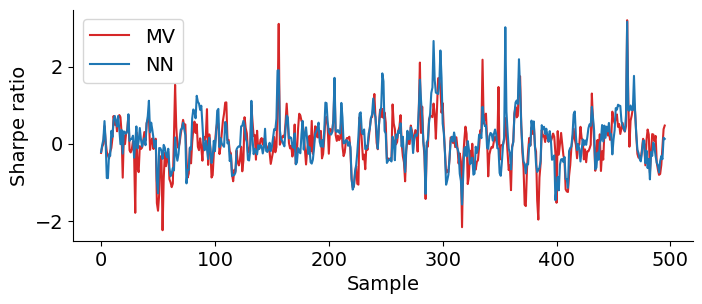

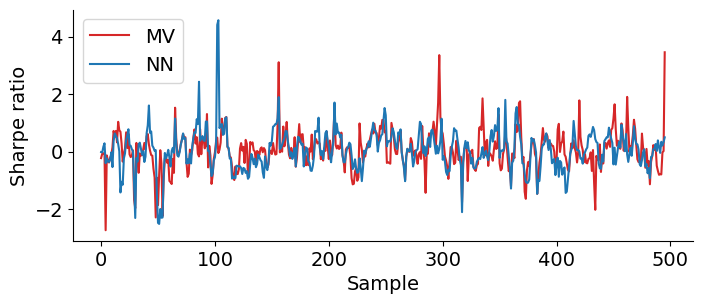

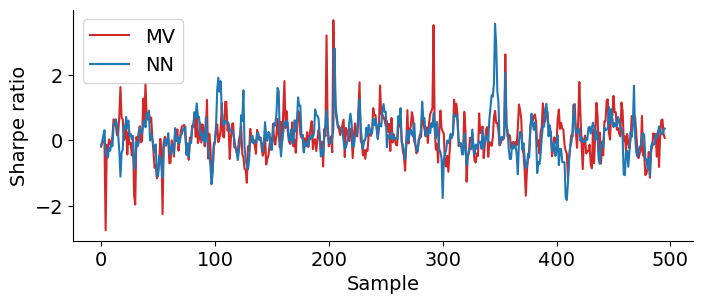

In [20]:
for n_stocks in [3, 5, 10]:
    plt.figure(figsize = (8, 3))
    plt.plot(sharpes_test[f"MV_{n_stocks}"], label = "MV", color = "tab:red")
    plt.plot(sharpes_test[f"NN_{n_stocks}"], label = "NN", color = "tab:blue")

    plt.ylabel("Sharpe ratio", fontsize = 14)
    plt.xlabel("Sample", fontsize = 14)
    plt.tick_params(axis = "y", labelsize = 14)
    plt.tick_params(axis = "x", labelsize = 14)
    plt.legend(loc='upper left', fontsize = 14)

    plt.show()

